In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter

Num_samples = 2000 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

sigma_A = 1.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

K_inf = 3 # take to be large for a good approximation to the IBP

Pi, Z, mu, A, X = vi.generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)

K_approx = K_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(Num_samples, D, K_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_A, sigma_eps)

data_set = DataSet(X, K_approx, alpha, sigma_eps, sigma_A)

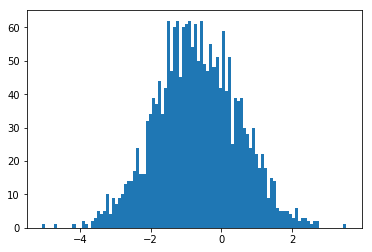

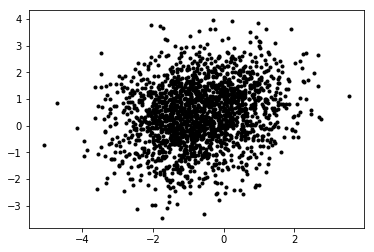

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(Pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [5]:
import time
par_hp_hess_time = time.time()
par_hp_hess = data_set.get_kl_sens_hess(params_init, hyper_params)
par_hp_hess_time = time.time() - par_hp_hess_time
print('Num samples: %d' % Num_samples)
print('Hessian time:')
print(par_hp_hess_time)

Num samples: 2000
Hessian time:
0.0165231227875


In [6]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

params = packing.flatten_params(tau, nu, phi_mu, phi_var)

max_iter = 100
tol = 1e-8
step = 0
diff = np.float('inf')

while diff > tol and step < max_iter:
    data_set.cavi_updates(tau, nu, phi_mu, phi_var)
    new_params = packing.flatten_params(tau, nu, phi_mu, phi_var)
    diff = np.max(np.abs(new_params - params))
    if step % 10 == 0:
        print 'Diff / tol at iter %d: %f' % (step, diff  / tol)
    if not np.isfinite(diff):
        break
    params = new_params
    step = step + 1
    
print('Done at step %d' % step)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Diff / tol at iter 0: 168919832054.242676
Diff / tol at iter 10: 1574175973.153820
Diff / tol at iter 20: 1165477218.486979
Diff / tol at iter 30: 1007898565.551977
Diff / tol at iter 40: 830237993.058881
Diff / tol at iter 50: 693766289.017901
Diff / tol at iter 60: 599939223.807462
Diff / tol at iter 70: 538038795.599505
Diff / tol at iter 80: 498502292.532601
Diff / tol at iter 90: 474240273.417831
Done at step 100


In [7]:
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print np.all(np.isfinite(cavi_params))

True


In [8]:
vb_opt = optimize.minimize(
    lambda params: data_set.wrapped_kl(params, verbose=True),
    params_init, method='trust-ncg', jac=data_set.get_kl_grad, hessp=data_set.get_kl_hvp,
    tol=1e-6, options={'maxiter': 200, 'disp': True, 'gtol': 1e-6 })

6683.32332507
4770.12429866
2582.19240602
1411.75779453
926.856221044
721.446883099
630.217318648
568.914388537
457.6390044
250.073697635
248.829794304
-87.1118987812
-95.0413304979
-95.5451060943
-380.194846283
-403.594333607
-434.432336143
-461.611086987
-542.383715084
-553.214290518
-553.492903721
-553.60638797
-608.127333887
-608.606529777
-608.734781827
-551.910579068
-635.251536526
-635.794497724
-675.559427706
-676.055359286
-676.128899131
163.369191676
-692.664981017
-693.596688455
-693.646593881
-713.699286919
-714.237060204
-714.256037875
-714.259672006
-723.583727959
-724.369563956
-724.393030218
-726.039846959
-728.355047192
-730.088820414
-730.968210966
-730.987407162
-734.460766854
-734.515845564
-735.632296271
-736.182492924
-736.193877461
-737.411698454
-738.682824009
-738.749282689
-739.114490682
-740.133734682
-740.145951904
-740.150026887
-740.78489113
-740.466846168
-740.466846168
-740.988050915
-741.310430847
-741.314927369
-741.42581091
-741.934056927
-741.9351503

In [11]:
print 'CAVI:'
print cavi_phi_mu.transpose()

print 'Full TR:'
data_set.use_full_x()
tau, phi_mu, phi_var, nu = data_set.unpack_params(vb_opt.x)
print phi_mu.transpose()

print 'Truth:'
print A



CAVI:
[[ 0.28878376  1.11408704]
 [ 0.00612493 -0.03299233]
 [-1.20215924 -0.25802058]]
Full TR:
[[ 0.22606596  0.5906605 ]
 [-0.38076493  0.52819555]
 [-1.14955207 -1.01547681]]
Truth:
[[ 0.6158451   1.29983585]
 [-1.37563604 -0.82781326]
 [-0.10156513  0.08682283]]


Cavi residuals: 2759.87041829    Trust residuals: 2824.96363296


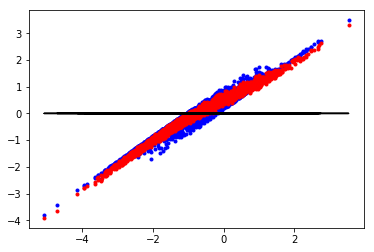

In [12]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(vb_opt.x)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}'.format(np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid))))
